In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
from scipy.fft import fft, fftfreq
import json

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


c:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [2]:
# %aimport experiments
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.amprabi_opt_ctrl_state_prep
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.crosstalk_echo_calib
imp

In [3]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [4]:
expt_path=os.path.join(os.getcwd(), 'data', 'data_240617')
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_240617


In [5]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join(os.getcwd(), config_file)
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and638_reset.yml


# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [6]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [7]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

In [8]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Software version: 0.2.267
	Firmware timestamp: Mon Jul 24 13:57:32 2023

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=43

In [9]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# TURN OFF
lo1.set_standby(True)
lo1.set_output_state(False)

# # TURN ON
# lo1.set_standby(False)
# lo1.set_output_state(True)
# lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
# lo_power = float(yaml_cfg.hw.lo.readout.power)
# lo1.set_frequency(lo_freq) # Set LO frequency
# print('set freq to', lo_freq)
# lo1.set_power(lo_power) # Set LO power
# print('set power to', lo_power)

Default Instrument SC_26C1


0

# QRAM t1 experiments

In [35]:
qramExpt = meas.QramVariantsT1Experiment(
    soccfg=soc,
    path=expt_path,
    config_file=config_path,
)

span = 350
npts = 151

qramExpt.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts,
    reps=1000, # number of reps per time step,
)

# qramExpt.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]

# print(qramExpt.cfg)

import Pyro4.util
try:
    qramExpt.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/151 [00:00<?, ?it/s]

Fit T1 avgi [us]: 39.14525202066193
Fit T1 avgq [us]: 33.939621234622734


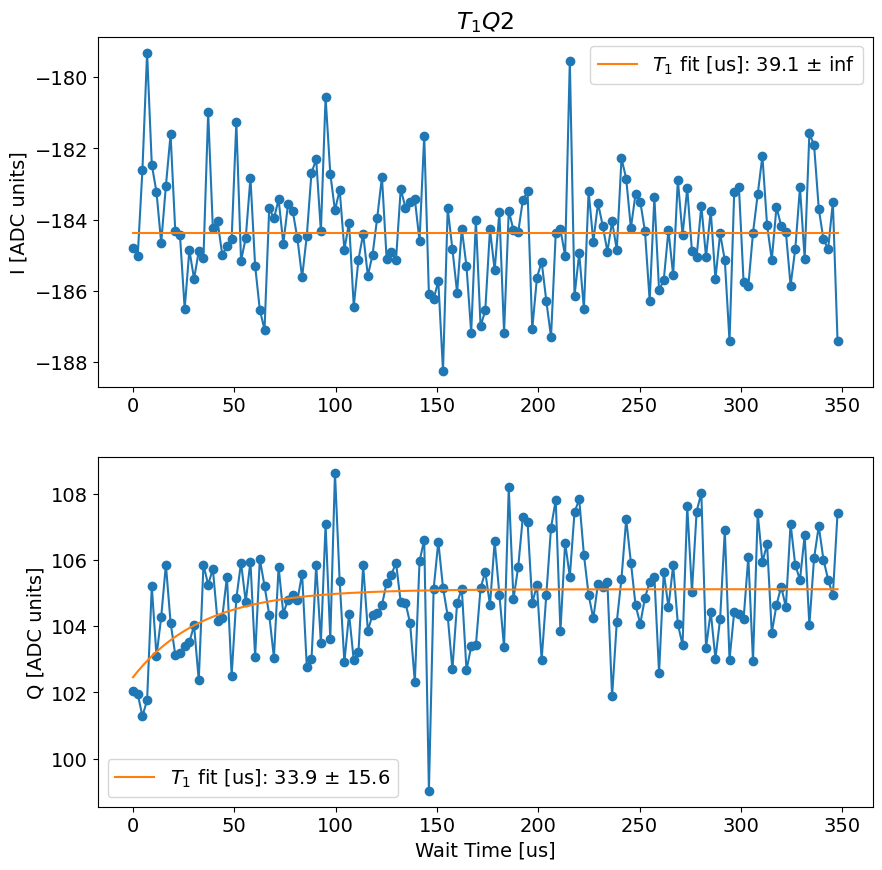

In [36]:
qubit = 2
qramExpt.analyze(qubit=qubit, fit=True)
qramExpt.display(qubit=qubit, fit=True)

In [34]:
# print(qramExpt.data)
qramExpt.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_231212\00000_QramT1.h5
('Error in saving cfg into datafile (experiment.py):', TypeError('Object of type range is not JSON serializable'))


's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_231212\\00000_QramT1.h5'

# Single shot multi hist experiments

In [66]:
qramExpt = meas.QramProtocolSingleShotExperiment(
    soccfg=soc,
    path=expt_path,
    config_file=config_path,
)

# always going to check |Qx>|Q1>
q_other = 2 # Qx

# check_states = ['|0>|0>', '|0>|1>',  '|1>|0>'] # for calibration angle: prepare variations on Qx and Q1
check_states = ['|0>|0>', '|0>|1>',  '|2>|0>'] # for calibration angle: prepare variations on Qx and Q1
if q_other != 0:
    for i in range(len(check_states)):
        check_states[i] = f'Q{q_other}Q1_' + check_states[i] 
play_pulses_list = [[0] for i in range(len(check_states))]

# check_states = ['|0>|0>', '|0>|1>', '|1>|0>', '|1>|1>', '|0+1>|0>', '|0+1>|1>', '|0>|0+1>', '|1>|0+1>']
# check_states_with_init = ['|0>|1>', '|1>|1>', '|0>|0>']
# check_states_with_init = ['|0>|1>']
check_states_with_init = [f'Q{q_other}Q1_|2T>|0>']
check_states += check_states_with_init # initialize on Q0, Q1
play_pulses_list += [[0] for i in range(len(check_states_with_init))]
# play_pulses_list += [[1] for i in range(len(check_states_with_init))]


# check_states = ['|0>|1>', '|1>|1>', '|0>|0>']
print(check_states)
print(play_pulses_list)


qramExpt.cfg.expt = dict(
    check_states=check_states,
    # play_pulses=[1, 3],
    # play_pulses=[2, 4],
    play_pulses_list=play_pulses_list,
    reps=40000, # number of reps per time step,
    q_other=q_other,

    # cool_qubits=[0, 1, 2],
    # cool_qubits=None,
)

# print('using readout frequency for ef distinguishing')
qramExpt.cfg.device.readout.frequency[q_other] = qramExpt.cfg.device.readout.frequency_ef[q_other]
qramExpt.cfg.device.readout.readout_length[q_other] = qramExpt.cfg.device.readout.readout_length_ef[q_other]

# qramExpt.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]

print(qramExpt.cfg)

import Pyro4.util
try:
    qramExpt.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

['Q2Q1_|0>|0>', 'Q2Q1_|0>|1>', 'Q2Q1_|2>|0>', 'Q2Q1_|2T>|0>']
[[0], [0], [0], [0]]
{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [-390.95193842109995, 5794.90833333, 499.41074988962544, -229.87577390000007], 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.37577390000007], 'gain': [0.25, 0.3, 0.85, 0.45], 'readout_length': [8.0, 10.0, 4.0, 6.0], 'readout_length_ef': [8.0, 7.0, 4.0, 4.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4110.4153676, 3448.27468154, 4762.18307375, 4381.643639996708], 'f_ef': [3884.3809607535322, 3347.761789059698, 4572.375572742949, 4209.906361998122], 'f_Q1_ZZ': [3442.909184486008, 0, 3447.0924878770584, 3446.9608452525486], 'f_Q_ZZ1': [4104.8259754819555, 0, 4761.14068386677, 4380.292188886469], 'f_ef_Q_ZZ1': [0, 0, 4570.466450039196, 4207.199191279], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q': [0, 0, 5883.9, 5146.885], 'f_f0g1': [1184.4, 999.8, 1632.98

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

Q2, Q1
['Q2Q1_|0>|0>', 'Q2Q1_|0>|1>', 'Q2Q1_|2>|0>', 'Q2Q1_|2T>|0>']
Q2Q1_|0>|0> play_pulses [0] unrotated medians:
I 12.81326281529699 +/- 170.13912434894027 	 Q 934.1977217249796 +/- 169.66695023225597 	 Amp 934.2855896245625
Rotated (theta=2.0573407680526867):
I -832.5762066678908 +/- 170.38906149948 	 Q -426.651100330241 +/- 169.4159477636784 	 Amp 935.5288885558263
Q2Q1_|0>|1> play_pulses [0] unrotated medians:
I 14.34540276647681 +/- 168.7097995203352 	 Q 932.919446704638 +/- 169.99417915832106 	 Amp 933.0297340493604
Rotated (theta=2.0573407680526867):
I -830.5320447375977 +/- 170.00822084292903 	 Q -424.20212520202875 +/- 168.69564975933707 	 Amp 932.5936523277074
Q2Q1_|2>|0> play_pulses [0] unrotated medians:
I -168.3474369406021 +/- 202.3242291825467 	 Q 529.5516680227827 +/- 238.7960003006784 	 Amp 555.6670123645829
Rotated (theta=2.0573407680526867):
I -379.72407416835017 +/- 255.80297575767344 	 Q -401.66894350911616 +/- 180.34262132793899 	 Amp 552.7461557376408
Q2Q1_|2T>

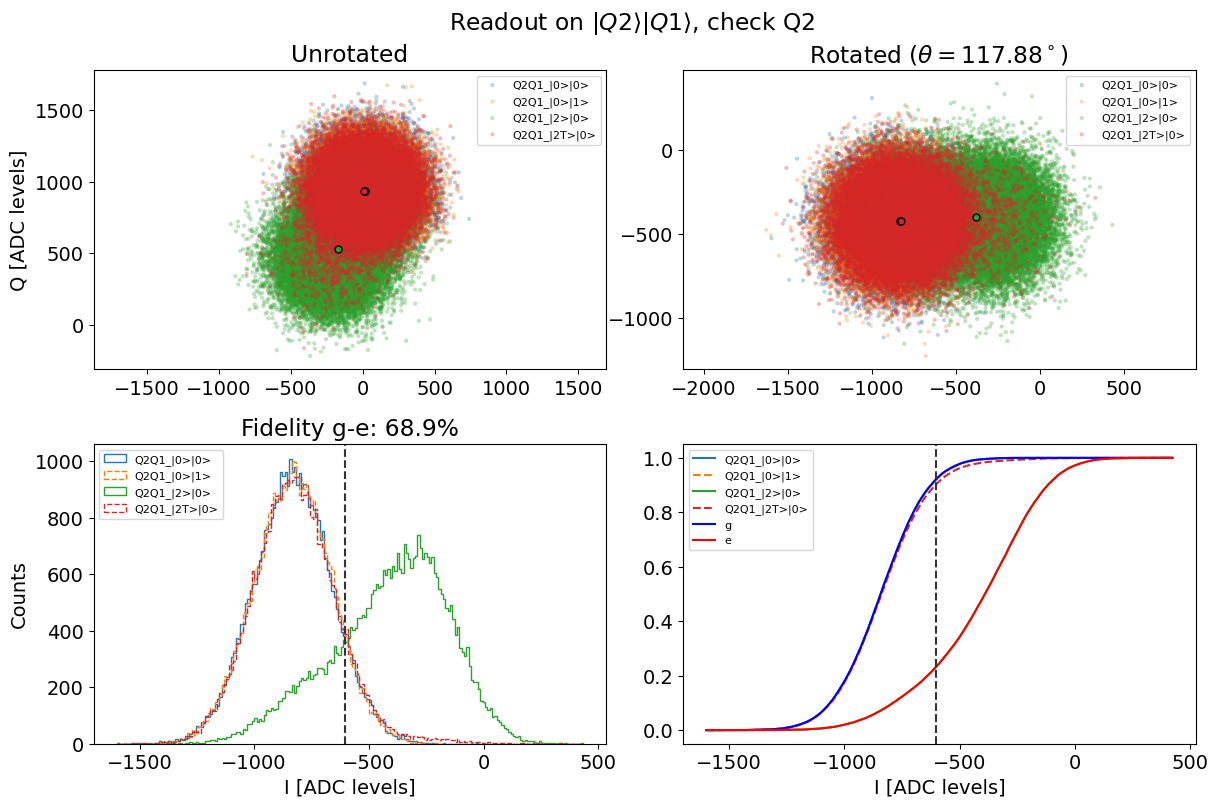

average ge fidelity (%): 68.905
rotation angle (deg): 117.87694302962218
threshold ge: -602.9734323885555


In [67]:
# TESTING
# qramExpt = meas.QramProtocolSingleShotExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_QramSingleShotHist.h5')
# qramExpt.data = temp_data
# qramExpt.cfg = AttrDict(attrs['config'])
# check_states = qramExpt.cfg.expt.check_states
# if check_states[0][2:5] == 'Q1_': q_other = int(check_states[0][1])
# else: q_other = 0


check_qubit = q_other
# check_qubit = 1

# Define the states to use for the rotation of g/e
if check_qubit == 1:
    g_states = [0]
    e_states = [1]
else:
    g_states = [0]
    e_states = [2]


print(f'Q{q_other}, Q1')
print(check_states)

qramExpt.display(data=None, check_qubit=check_qubit, qubits=[q_other, 1], play_pulses_list=qramExpt.cfg.expt.play_pulses_list, theta=None, check_states=check_states, g_states=g_states, e_states=e_states, verbose=True)

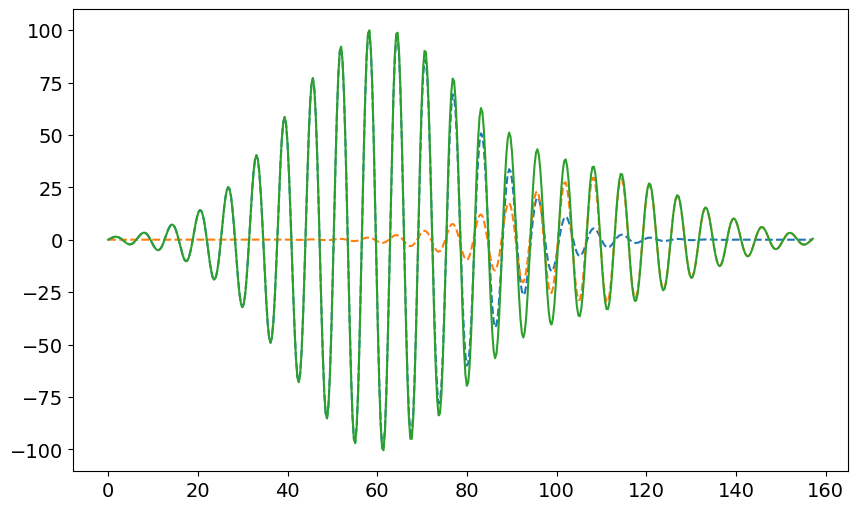

In [35]:
tpts = np.linspace(0, 50*np.pi, 500)
a = 100
b = 30
t_offset = 50
def gaussian(x, sigma):
    return np.exp(-x**2/2/sigma**2)

y1 = a*np.sin(tpts)*gaussian(tpts-60, 20)
y2 = b*np.sin(tpts - t_offset)*gaussian(tpts-60-t_offset, 20)
plt.plot(tpts, y1, '--')
plt.plot(tpts, y2, '--')
plt.plot(tpts, y1+y2)
plt.show()

In [55]:
# print(qramExpt.data)
qramExpt.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00022_QramSingleShotHist.h5


# Run protocol with 3Q calibration

In [ ]:
qramExpt = meas.QramProtocol3QTomoExperiment(
    soccfg=soc,
    path=expt_path,
    config_file=config_path,
    prefix=f"qram_protocol_timestepped_4Q_calib",
)

span = 0.5 # total time [us]
npts = 2
print('time step size [cycles]:', soc.us2cycles(span/npts))

qramExpt.cfg.expt = dict(
    init_state='|0+1>|1>',
    start=0, # start protocol time [us],
    step=span/(npts-1), # time step [us], 
    expts=npts, # number of different time experiments, 
    reps=10000, # number of reps per time step,
    singleshot_reps=10000, # reps per state for singleshot calibration
    measure_f=[2, 3],
    setup_q1_e=True,
    # measure_f=None,
    tomo_3q=False,
    tomo_qubits=[0,2,3],
    post_process='threshold', # scale, threshold
    # thresholds=[-32.64691949520454, 0, 31.3188836125708, 86.06777840545668],
    # angles=[162.4329570249908, 0, 64.32474484855494, 135.66318585876542],
    # ge_avgs=[[59.504379895901096, -11.582164866623291, 23.711639297332464, -22.922088223812626], 0, [17.739780351333767, -26.9960761223162, 32.536323812621994, -55.67121184124919], [-60.43007885491217, -30.232965972674045, -89.79383272608978, -59.152381457384514]],
    # counts_calib=[array([3189,  426, 3176,  519, 1176,  198, 1110,  206]), array([ 580, 3047,  582, 3015,  207, 1148,  221, 1200]), array([1963,  289, 4456,  583,  721,   97, 1661,  230]), array([ 390, 1850,  812, 4372,  130,  683,  269, 1494]), array([1336,  209, 1293,  232, 2954,  473, 2981,  522]), array([ 256, 1341,  226, 1320,  512, 2924,  557, 2864]), array([ 809,  118, 1892,  295, 1810,  262, 4215,  599]), array([ 167,  796,  352, 1830,  325, 1776,  781, 3973])]
)

# qramExpt.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]

# print(qramExpt.cfg)

import Pyro4.util
try:
    qramExpt.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

['ggg' 'gge' 'geg' 'gee' 'egg' 'ege' 'eeg' 'eee']
[[3205  507 3066  450 1194  198 1151  229]
 [ 516 3236  484 3068  184 1174  192 1146]
 [2025  313 4349  674  674  123 1583  259]
 [ 342 1965  738 4406  139  665  261 1484]
 [1569  214 1554  245 2818  410 2729  461]
 [ 271 1555  269 1518  432 2766  436 2753]
 [1008  144 2056  339 1717  241 3889  606]
 [1573  244 1506  234 2733  455 2831  424]]
[[[2334  327 2188  295 2131  301 2106  318]]

 [[1695  251 2876  428 1905  298 2198  349]]]
[[[ 242 1354  466 3157  197 1298  476 2810]]

 [[ 441 1216 1140 2538  251 1150  691 2573]]]
corrected counts1 [4383.31232281   14.74318054   10.42893614   34.19043284 2602.67904217
    0.          113.55924584 2841.08684967]
corrected counts2 [ 999.70391244  586.22742052  312.20186833 1011.54146915 4833.86804448
  988.16263017 1268.29466491    0.        ]
corrected counts1 [  73.47108084  240.41867408 4236.77086194  119.58927176 3667.51248997
  180.08688817    0.         1482.15074324]
corrected counts2 [ 95

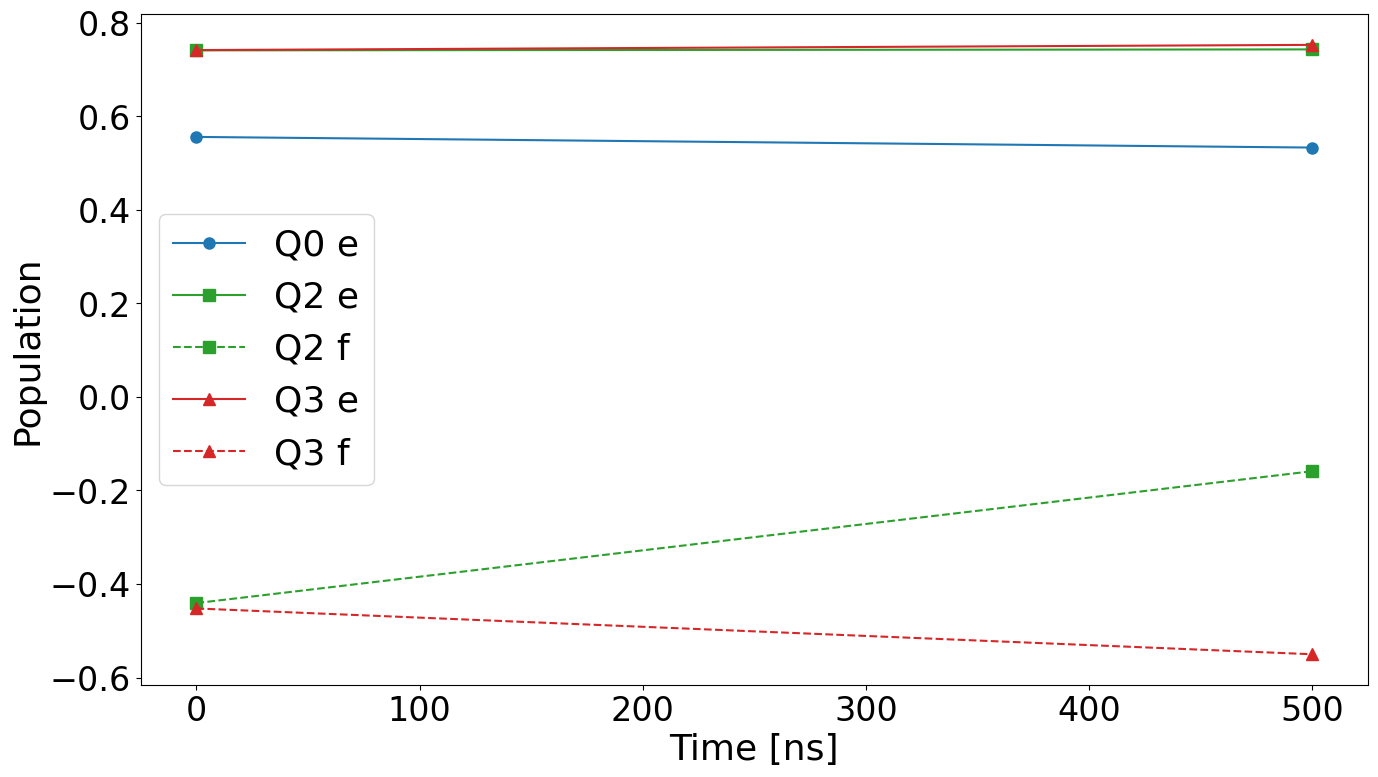

In [170]:
print(qramExpt.calib_order)
print(qramExpt.data['counts_calib'])
print(qramExpt.data['counts_raw'][0])
print(qramExpt.data['counts_raw'][1])
qramExpt.analyze(data=None)
qramExpt.display(data=None)

# Run protocol with 4Q calibration

In [85]:
counts = np.array([[-750, -250, 1000, 500]])
for i_n, n in enumerate(counts):
    if len(n[n<0]) == 0: continue
    old_sum = sum(n)
    assert old_sum > 0, 'Negative sum of counts somehow'
    neg_indices = np.where(n<0)[0]
    for i in neg_indices: n[i] = 0
    new_sum = sum(n)
    for i in range(len(n)): # we don't want to scale the previously negative indices because in the ideal case, you would only have positive counts in a few elements. if there were negative counts somewhere, those could not have had population (i think?)
        if i not in neg_indices: n[i] *= old_sum/new_sum
print(counts)

[[  0   0 333 166]]


In [64]:
qramExpt = meas.QramProtocolExperiment4Q(
    soccfg=soc,
    path=expt_path,
    config_file=config_path,
    prefix=f"qram_protocol_timestepped_4Q_calib",
)

span = 0.5 # total time [us]
npts = 2
print('time step size [cycles]:', soc.us2cycles(span/npts))

qramExpt.cfg.expt = dict(
    init_state='|1>|1>',
    start=0, # start protocol time [us],
    step=span/npts, # time step [us], 
    expts=npts, # number of different time experiments, 
    reps=100000, # number of reps per time step,
    singleshot_reps=100000, # reps per state for singleshot calibration
    measure_f=None, # [2, 3],
    post_process='threshold', # scale, threshold
    thresholds=[-32.34393077808804, -429.93280953050476, 41.34693486551805, 83.15004309885798],
    angles=[161.59121494290602, -164.62581598368104, 60.47284033980248, 136.22050345385662],
    ge_avgs=[[58.42829931034483, -9.812820748210802, 24.027274703968768, -21.28550835393624], [212.06976247234877, -1554.7151353675995, -177.73544549772282, -1441.9476171177616], [17.0924195575797, -26.717151698113206, 29.271657241379305, -48.4234194209499], [-59.81379383214054, -28.74510220559532, -89.75425539362394, -57.60756237475602]],
    counts_calib=[array([25082,  3858, 19263,  2979,  9946,  1798,  7874,  1576,  9074,
        1513,  7032,  1332,  3847,   858,  3150,   818]), array([ 4169, 24918,  3177, 18767,  1692, 10407,  1343,  8250,  1474,
        8884,  1197,  6967,   660,  4026,   525,  3544]), array([18142,  2752, 26683,  4037,  7415,  1228, 10913,  1713,  6596,
        1083,  9634,  1564,  2790,   528,  4110,   812]), array([ 3135, 17711,  4457, 25485,  1398,  7922,  1993, 11664,  1078,
        6202,  1552,  8910,   508,  3000,   718,  4267]), array([ 9727,  1446,  7392,  1180, 27327,  3550, 20440,  2670,  3578,
         564,  2750,   432,  9544,  1335,  7069,   996]), array([ 1714,  9551,  1290,  7079,  4299, 26715,  3168, 20058,   645,
        3516,   489,  2686,  1516,  9138,  1089,  7047]), array([ 6718,   976, 10239,  1537, 19066,  2472, 29145,  3817,  2444,
         346,  3767,   606,  6646,   880, 10010,  1331]), array([ 1290,  6498,  1791, 10017,  3379, 18231,  4675, 27856,   460,
        2454,   681,  3567,  1211,  6449,  1639,  9802]), array([10214,  1838,  7947,  1463,  4925,  1029,  3966,   937, 21569,
        3737, 16574,  3247, 10241,  2269,  8032,  2012]), array([ 1530, 10289,  1254,  8021,   758,  5252,   669,  4172,  3428,
       21749,  2763, 17004,  1628, 11056,  1346,  9081]), array([ 7502,  1224, 10895,  1973,  3551,   701,  5470,  1027, 15651,
        2676, 22965,  4052,  7449,  1465, 11218,  2181]), array([ 1206,  7689,  1757, 10971,   609,  3979,   914,  5958,  2466,
       15752,  3318, 21817,  1284,  8448,  1836, 11996]), array([ 5361,   811,  4164,   633, 14071,  1981, 10539,  1529,  8017,
        1269,  6077,  1128, 22330,  3255, 16474,  2361]), array([  800,  4997,   624,  3801,  2102, 13214,  1571,  9852,  1351,
        8233,  1008,  6178,  3413, 22971,  2606, 17279]), array([ 3872,   617,  5603,   842, 10336,  1459, 14796,  1991,  5773,
         970,  8368,  1308, 15866,  2206, 22774,  3219]), array([ 4651,   692,  5034,   746, 11964,  1677, 13583,  1875,  6560,
        1074,  7382,  1152, 18031,  2517, 20231,  2831])]
)

# qramExpt.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]

# print(qramExpt.cfg)

import Pyro4.util
try:
    qramExpt.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

time step size [cycles]: 108
timesteps [0.   0.25]
Re-using provided angles, thresholds, ge_avgs


  0%|          | 0/2 [00:00<?, ?it/s]

DETERMINANT 7.493367889993323e-17
DETERMINANT 7.493367889993323e-17
end times []


In [53]:
# counts_calib=[array([5209,  749, 3627,  586, 2129,  364, 1434,  282, 1983,  305, 1372,
#         249,  791,  184,  578,  158]), array([ 881, 5234,  564, 3498,  325, 2126,  245, 1568,  333, 1962,  218,
#        1371,  130,  824,  100,  621]), array([3672,  564, 5221,  793, 1506,  238, 2166,  346, 1372,  221, 1904,
#         327,  618,   97,  829,  126]), array([ 615, 3675,  874, 4971,  284, 1595,  353, 2280,  218, 1302,  306,
#        1759,  106,  640,  150,  872]), array([1860,  252, 1209,  191, 5999,  750, 3911,  453,  682,  110,  452,
#          71, 2118,  272, 1492,  178]), array([ 309, 1794,  213, 1283,  935, 5725,  613, 3801,  109,  668,   82,
#         429,  332, 2040,  240, 1427]), array([1339,  197, 1735,  247, 4119,  534, 5869,  708,  498,   61,  643,
#          82, 1511,  161, 2072,  224]), array([ 272, 1282,  361, 1674,  796, 4042,  918, 5366,   91,  450,  123,
#         615,  262, 1424,  343, 1981]), array([2287,  351, 1644,  255, 1031,  196,  691,  154, 4618,  754, 3046,
#         578, 2075,  449, 1514,  357]), array([ 366, 2200,  257, 1495,  147, 1048,  102,  730,  734, 4481,  486,
#        3252,  340, 2403,  275, 1684]), array([1647,  239, 2276,  335,  751,  137, 1056,  166, 3233,  466, 4532,
#         715, 1591,  273, 2186,  397]), array([ 238, 1469,  338, 2092,  134,  805,  187, 1079,  542, 3252,  726,
#        4277,  280, 1690,  408, 2483]), array([ 875,  130,  596,   91, 2579,  304, 1632,  224, 1653,  228, 1164,
#         163, 5543,  673, 3689,  456]), array([ 143,  883,  102,  582,  391, 2383,  240, 1529,  340, 1611,  207,
#        1133,  907, 5455,  603, 3491]), array([ 592,   75,  914,  130, 1721,  213, 2287,  294, 1210,  174, 1630,
#         212, 3896,  496, 5497,  659]), array([ 733,  102,  751,  123, 2015,  252, 2190,  214, 1399,  198, 1453,
#         192, 4411,  582, 4785,  600])]
# from experiments.two_qubit.twoQ_state_tomography import AbstractStateTomo2QProgram, ErrorMitigationStateTomo2QProgram, sort_counts, correct_readout_err, fix_neg_counts, infer_gef_popln

# # counts_calib = np.array(counts_calib)
# # counts_calib //= 200
# # print(counts_calib)

# # introduce gaussian noise
# print(0)
# n = np.copy([counts_calib[12]])
# print(n, sum(n))
# n0 = correct_readout_err(n, n_conf=counts_calib)
# print(n0)
# print(fix_neg_counts(n0))

# np.random.seed(0)
# noise = 5.0
# if noise is not None:
#     for n_psi in n:
#         n_meas = sum(n_psi)
#         new_nlast = -1
#         while new_nlast < 0:
#                 new_n_uptolast = np.random.normal(loc=n_psi[:-1], scale=noise*np.sqrt(n_psi[:-1]))
#                 # new_n_uptolast *= 1 - np.isnan(new_n_uptolast) # 0 out the nans
#                 # print('here', new_n_uptolast)
#                 # preserve original total count per measurement
#                 new_nlast = n_meas - sum(new_n_uptolast)
#                 n_psi[:-1] = np.round(new_n_uptolast)
#                 n_psi[-1] = np.round(new_nlast)

# print(1)
# print(n, sum(n))
# print(type(n))
# print(np.shape(n))
# print(n[0].dtype)
# n1 = np.array(n, dtype=float)
# n1 = correct_readout_err(n, n_conf=counts_calib)
# print(n1)
# print(fix_neg_counts(n1))

# print(2)
# n2 = [array([1029,  147,  560,  -13, 2715,    2, 1935,  368, 1030,  412,  942,
#         158, 5627,  870, 4122,   95])]
# print(n2)
# n2 = correct_readout_err(n2, n_conf=counts_calib)
# print(n2)
# print(fix_neg_counts(n2))

# print('n1-n2')
# print(n1-n2)

# print(3)
# n = [array([1014,  147 , 707   ,99, 2497,  336, 1675,  261, 1795,  282, 1139,  161, 5264,  716,
#    3449,  458], dtype=float)]
# print(n)
# n = correct_readout_err(n, n_conf=counts_calib)
# print(n)
# print(fix_neg_counts(n))

# print(4)
# correct_readout_err(counts_calib, counts_calib)

In [54]:
# # Open old data
# data, attrs = prev_data(expt_path, '00000_qram_protocol_timestepped_4Q_calib.h5')

DETERMINANT 7.493367889993323e-17
DETERMINANT 7.493367889993323e-17


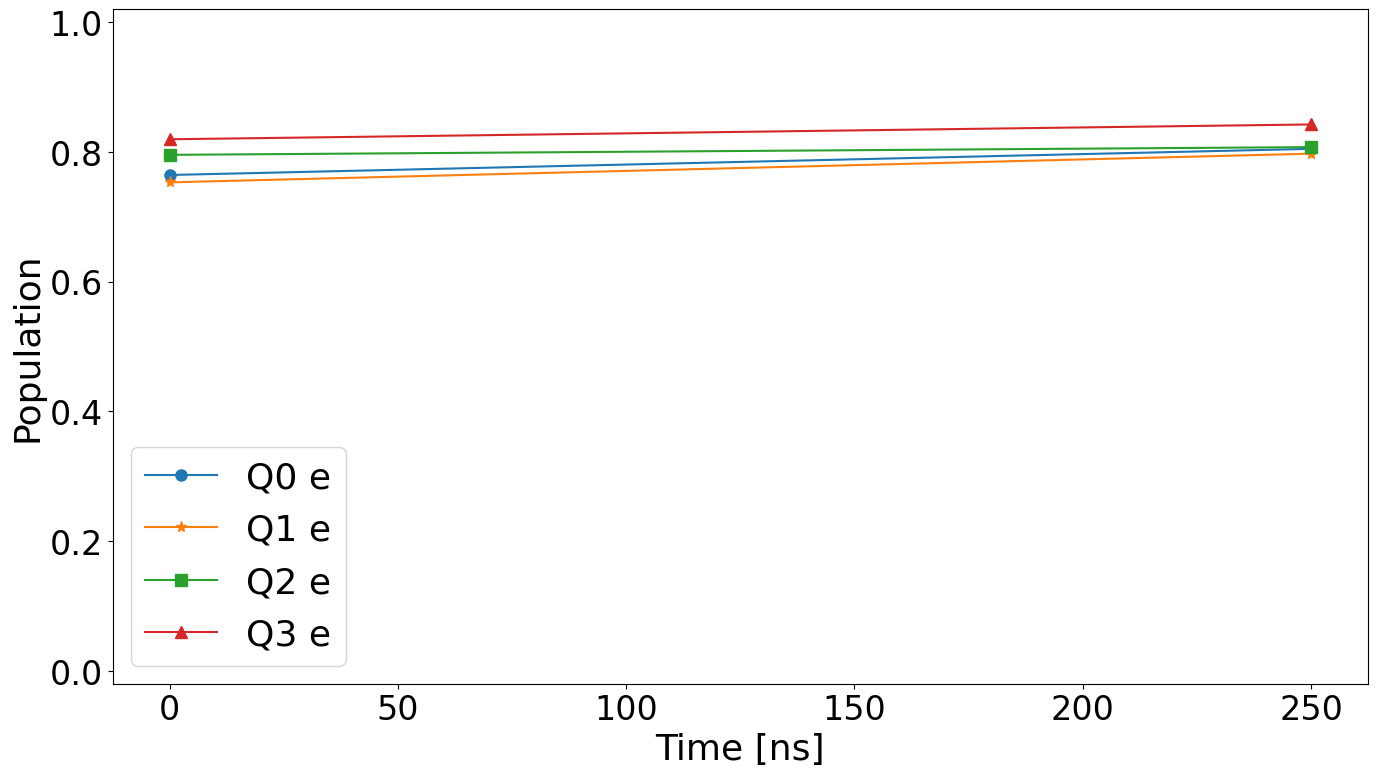

In [66]:
qramExpt.analyze(data=None)
qramExpt.display(data=None)

In [65]:
# qramExpt.save_data()

In [43]:
data, attrs = prev_data(expt_path, '00000_qram_protocol_timestepped_4Q_calib.h5')

xpts_ns = data['xpts']*1e3

# ---- Subtract off baseline for when there are no coupled qubits in excited state ---- #
ti = np.argmin(np.abs(xpts_ns - 1250))
tf = -1

for q in range(4):
    q_baseline = np.average(data['avgi'][q][ti:tf])
    # plt.axhline(q_baseline, color='0.6', linestyle='--')
    print(q, ti, tf, q_baseline)
    data['avgi'][q] -= q_baseline

data_q0_raw = data["avgi"][0]
data_q1_raw = data["avgi"][1]
data_q2_raw = data["avgi"][2]
data_q3_raw = data["avgi"][3]


data_q = ([], [], [], [])
xpts_ns_smoothed = []

# test = np.arange(len(data_q0_raw))
# print(len(data_q0_raw))

window_size = 1
start_window = 0
for q, data_raw in enumerate((data_q0_raw, data_q1_raw, data_q2_raw, data_q3_raw)):
    # smoothing over window
    if start_window > 0:
        data_q[q].append(data_raw[:start_window])
        if q == 0: xpts_ns_smoothed.append(xpts_ns[:start_window])
    for n in range(1, (len(data_raw) - start_window)//window_size + 1):
        # print(n, test[(n-1)*window_size+start_window:n*window_size+start_window])
        if q == 0: xpts_ns_smoothed.append(np.average(xpts_ns[(n-1)*window_size+start_window:n*window_size+start_window]))
        data_q[q].append(np.average(data_raw[(n-1)*window_size+start_window:n*window_size+start_window]))
    if (len(data_raw) - start_window) % window_size > 0:
        n = (len(data_raw) - start_window)//window_size
        print(test[n*window_size+start_window:])
        if q == 0: xpts_ns_smoothed.append(np.average(xpts_ns[n*window_size+start_window:]))
        data_q[q].append(np.average(data_raw[n*window_size+start_window:]))

plt.plot(xpts_ns_smoothed, data_q[0], '-', marker='o', markersize=4, label='Q0')
plt.plot(xpts_ns_smoothed, data_q[1], '-', marker='*', markersize=6, label='Q1')
plt.plot(xpts_ns_smoothed, data_q[2], '-', marker='s', markersize=3, label='Q2')
plt.plot(xpts_ns_smoothed, data_q[3], '-', marker='^', markersize=4, label='Q3')
plt.axhline(0, color='0.6', linestyle='--')
plt.axhline(1, color='0.6', linestyle='--')

plt.legend(fontsize=20, loc='upper right')
plt.xticks([0, 500, 1000, 1500], fontsize=18)
plt.yticks([0, 0.25, 0.5, 0.75, 1], labels=['0', '0.25', '0.5', '0.75', '1'], fontsize=16)
plt.xlabel('Time (ns)', fontsize=20)
plt.ylabel("Population", fontsize=20)

plt.savefig('mux_readout_expt.pdf')
plt.show()


Extracted data and attrs ['calib_order', 'meas_order', 'pulse_dict']


C:\Users\slab\AppData\Local\Temp\ipykernel_15400\217307492.py:11: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  temp_data.update({key:np.array(a[key])})


KeyError: 'avgi'